In [1]:
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import requests
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sokal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sokal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sokal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
print("Fetching data")
tweets_data = requests.get("http://localhost:8000/tweets/dataset/?discipline=Tennis").json()
print(f"Data fetched: {len(tweets_data)} tweets")
df = pd.DataFrame(tweets_data)
print(df)
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()
    return text

def build_vocab(tokens_list):
    vocab = {'<pad>': 0, '<unk>': 1}
    for tokens in tokens_list:
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

Fetching data
Data fetched: 31642 tweets
                                                 content  outcome     home  \
0      It's kind of weird seeing Malakai without any ...        1    Nardi   
1      The Epic Games v. Apple contempt-of-court hear...        1    Nardi   
2      Running a pitch count up doesn’t mean shit if ...        1    Nardi   
3      MAGA: The Pine Flag was from George Washington...        1    Nardi   
4      It’s finale day ChiHards!!!!! Live tweeting is...        1    Nardi   
...                                                  ...      ...      ...   
31637  Matches to Watch #RolandGarros 2024 Day 2:\n\n...        1  Monfils   
31638  ATP French Open\n\nMonfils G. - Seyboth Wild T...        1  Monfils   
31639  Thiago Seyboth Wild vs. Gael Monfils\n\nWild m...        1  Monfils   
31640  Roland Garros \n Men's \n Most unpredictable m...        1  Monfils   
31641                      Monfils Seyboth Wild en night        1  Monfils   

          away  
0    

In [5]:
# Filtering unrelated tweets
filtered_keywords = ['wizards', 'jazz', 'magic']
df = df[~df['content'].str.contains('|'.join(filtered_keywords), case=False)]

df['clean_content'] = df['content'].apply(clean_text)
df['tokens'] = df['clean_content'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

unique_teams =  pd.concat([df['home'], df['away']]).unique()
team_vocab = {team: idx for idx, team in enumerate(unique_teams)}
#team_vocab = {team: idx for idx, team in enumerate(df['home'].unique())}
df['home_team_idx'] = df['home'].apply(lambda team: team_vocab[team])
df['away_team_idx'] = df['away'].apply(lambda team: team_vocab[team])
vocab = build_vocab(df['tokens'])

synonym_aug = naw.SynonymAug(aug_src='wordnet')
print(df)

                                                 content  outcome     home  \
0      It's kind of weird seeing Malakai without any ...        1    Nardi   
1      The Epic Games v. Apple contempt-of-court hear...        1    Nardi   
2      Running a pitch count up doesn’t mean shit if ...        1    Nardi   
3      MAGA: The Pine Flag was from George Washington...        1    Nardi   
4      It’s finale day ChiHards!!!!! Live tweeting is...        1    Nardi   
...                                                  ...      ...      ...   
31637  Matches to Watch #RolandGarros 2024 Day 2:\n\n...        1  Monfils   
31638  ATP French Open\n\nMonfils G. - Seyboth Wild T...        1  Monfils   
31639  Thiago Seyboth Wild vs. Gael Monfils\n\nWild m...        1  Monfils   
31640  Roland Garros \n Men's \n Most unpredictable m...        1  Monfils   
31641                      Monfils Seyboth Wild en night        1  Monfils   

          away                                      clean_conte

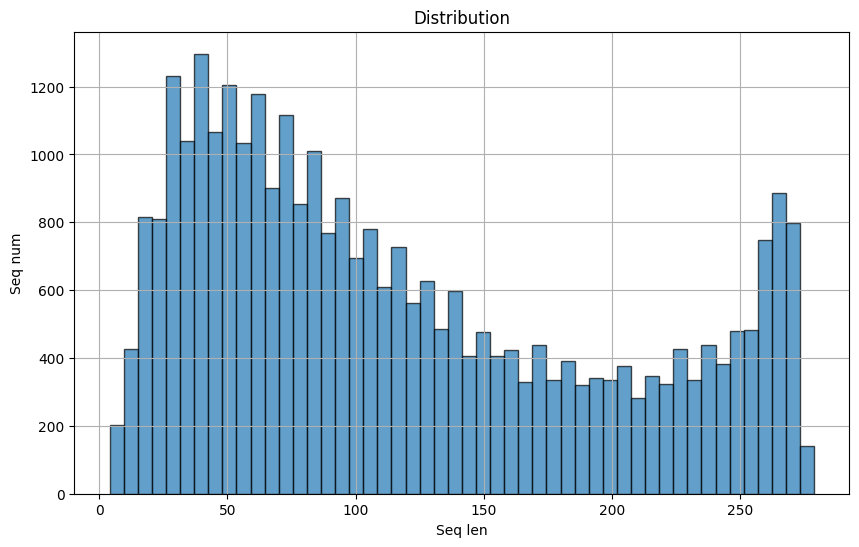

50 percentyl: 97.0
75 percentyl: 179.0
90 percentyl: 250.0
95 percentyl: 264.0
99 percentyl: 272.0


In [6]:
sequence_lengths = [len(seq) for seq in df['clean_content']]

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Seq len')
plt.ylabel('Seq num')
plt.title('Distribution')
plt.grid(True)
plt.show()

percentiles = np.percentile(sequence_lengths, [50, 75, 90, 95, 99])
for i, percentile in enumerate([50, 75, 90, 95, 99]):
    print(f"{percentile} percentyl: {percentiles[i]}")

In [7]:

max_len = 262
def augment_tweet(row):
    if isinstance(row['clean_content'], str): 
        content = row['clean_content']
        home_team = row['home'].lower()
        away_team = row['away'].lower()
        content = content.replace(home_team, f"<HOME_TEAM>")
        content = content.replace(away_team, f"<AWAY_TEAM>")

        augmented_content = synonym_aug.augment(content)
        if isinstance(augmented_content, list):  
            augmented_content = ' '.join(augmented_content)
            
        augmented_content = augmented_content.replace("<HOME_TEAM>", home_team)
        augmented_content = augmented_content.replace("<AWAY_TEAM>", away_team)

        augmented_tokens = word_tokenize(augmented_content)
        augmented_tokens = [token for token in augmented_tokens if token not in stop_words]
        augmented_encoded = encode_tokens(augmented_tokens, vocab)
        padded_content = augmented_encoded[:max_len] + [vocab['<pad>']] * (max_len - len(augmented_encoded))
        return pd.Series({
            'content': row['content'],
            'clean_content': augmented_content,
            'tokens': augmented_tokens,
            'encoded_content': augmented_encoded,
            'padded_content': padded_content,
            'home': row['home'],
            'away': row['away'],
            'home_team_idx': row['home_team_idx'],
            'away_team_idx': row['away_team_idx'],
            'outcome': row['outcome']
        })
    else:
        return row

augmented_df = df.apply(augment_tweet, axis=1)
print(augmented_df[:10])
augmented_df = augmented_df.dropna().reset_index(drop=True)
df = pd.concat([df, augmented_df], ignore_index=True)

vocab = build_vocab(df['tokens'])
vocab_size = len(vocab)

df['encoded_content'] = df['tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))

                                             content  \
0  It's kind of weird seeing Malakai without any ...   
1  The Epic Games v. Apple contempt-of-court hear...   
2  Running a pitch count up doesn’t mean shit if ...   
3  MAGA: The Pine Flag was from George Washington...   
4  It’s finale day ChiHards!!!!! Live tweeting is...   
5     Ty France has more home runs than Ronald Acuna   
6  Good luck to our Track & Field athletes at @OH...   
7  If they really wanted to make that Deadpool mo...   
8  Ty Cobb, The guy who was Trump’s lawyer during...   
9  Gonna make a Bludnymph playlist @bludnymph wha...   

                                       clean_content  \
0  its form of weird project malakai without any ...   
1  the epic games v orchard apple tree contemptof...   
2  running a pitch count upward doesnt mean turd ...   
3  maga the pine flag constitute from george wash...   
4  its finale day chihards dwell tweeting is yet ...   
5     ty france own more home runs than ronald 

In [8]:
df['padded_content'] = df['encoded_content'].apply(lambda x: x[:max_len] + [vocab['<pad>']] * (max_len - len(x)))

# Convert to tensors
X_text = torch.tensor(df['padded_content'].tolist(), dtype=torch.long)
X_home = torch.tensor(df['home_team_idx'].tolist(), dtype=torch.long)
X_away = torch.tensor(df['away_team_idx'].tolist(), dtype=torch.long)
y = torch.tensor(df['outcome'].tolist(), dtype=torch.long)

class_0_indices = np.where(y.numpy() == 0)[0]
class_1_indices = np.where(y.numpy() == 1)[0]

if len(class_0_indices) > len(class_1_indices):
    class_0_indices = np.random.choice(class_0_indices, len(class_1_indices), replace=False)
else:
    class_1_indices = np.random.choice(class_1_indices, len(class_0_indices), replace=False)
balanced_indices = np.concatenate((class_0_indices, class_1_indices))

X_text_balanced = X_text[balanced_indices]
X_home_balanced = X_home[balanced_indices]
X_away_balanced = X_away[balanced_indices]
y_balanced = y[balanced_indices]

X_text_train, X_text_test, X_home_train, X_home_test, X_away_train, X_away_test, y_train, y_test = train_test_split(
    X_text_balanced, X_home_balanced, X_away_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Class 0 samples: {sum(y_train.numpy() == 0)}")
print(f"Class 1 samples: {sum(y_train.numpy() == 1)}")


print(f"Original and augmented data combined: {len(df)} tweets")

class TweetDataset(Dataset):
    def __init__(self, X_text, X_home, X_away, y):
        self.X_text = X_text
        self.X_home = X_home
        self.X_away = X_away
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_text[idx], self.X_home[idx], self.X_away[idx], self.y[idx]

train_dataset = TweetDataset(X_text_train, X_home_train, X_away_train, y_train)
test_dataset = TweetDataset(X_text_test, X_home_test, X_away_test, y_test)

Class 0 samples: 17971
Class 1 samples: 18022
Original and augmented data combined: 63146 tweets


In [9]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, num_classes, team_vocab_size, dropout):
        super(CNN_LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.team_embedding = nn.Embedding(team_vocab_size, embedding_dim)

        self.conv1 = nn.Conv2d(1, 128, (3, embedding_dim))
        self.conv2 = nn.Conv2d(1, 128, (4, embedding_dim))
        self.conv3 = nn.Conv2d(1, 128, (5, embedding_dim))
        self.lstm = nn.LSTM(128 * 3, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(lstm_hidden_dim*2, lstm_hidden_dim, batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2 + embedding_dim * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x_text, x_home, x_away):
        x_text = self.embedding(x_text).unsqueeze(1)  # (batch_size, 1, max_len, embedding_dim)

        x1 = F.relu(self.conv1(x_text)).squeeze(3)
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)

        x2 = F.relu(self.conv2(x_text)).squeeze(3)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)

        x3 = F.relu(self.conv3(x_text)).squeeze(3)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)

        x_text = torch.cat((x1, x2, x3), 1).unsqueeze(1)  # (batch_size, 1, num_filters * 3)
        
        lstm_out, _ = self.lstm(x_text)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = lstm_out[:, -1, :]  # Ostatni wyjściowy stan ukryty z obu kierunków
        
        x_home = self.team_embedding(x_home)
        x_away = self.team_embedding(x_away)
        
        x = torch.cat((lstm_out, x_home, x_away), 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
embedding_dim = 256
lstm_hidden_dim = 512
num_classes = 2
dropout = 0.5
team_vocab_size = len(team_vocab)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN_LSTM_Model(vocab_size, embedding_dim, lstm_hidden_dim, num_classes, team_vocab_size, dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#, weight_decay=0.01
#Originals: lr = 0.001, epochs=20, dropout=0.5, decay=none
#latest = lr. 0.05, decay=0.001, dropout 0.75
# 90% - lr=0.001, decay=0.01, dropout= 0.5
# 90%/0.33 = lr=0.0005, decay=0.01, dr=0.75
# 95%/  optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01) dr-50


In [11]:
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_text_batch, X_home_batch, X_away_batch, y_batch in train_loader:
        X_text_batch, X_home_batch, X_away_batch, y_batch = X_text_batch.to(device), X_home_batch.to(device), X_away_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_text_batch, X_home_batch, X_away_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_text_batch, X_home_batch, X_away_batch, y_batch in test_loader:
            X_text_batch, X_home_batch, X_away_batch, y_batch = X_text_batch.to(device), X_home_batch.to(device), X_away_batch.to(device), y_batch.to(device)
            outputs = model(X_text_batch, X_home_batch, X_away_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy after epoch {epoch+1}: {accuracy:.2f}')

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.savefig('train_loss.png')
plt.close()

plt.figure()
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.savefig('test_accuracy.png')
plt.close()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color) 
ax2.plot(test_accuracies, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train Loss and Test Accuracy Over Epochs')
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.savefig('loss_vs_accuracy.png')
plt.close()

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for X_text_batch, X_home_batch, X_away_batch, y_batch in test_loader:
        X_text_batch, X_home_batch, X_away_batch, y_batch = X_text_batch.to(device), X_home_batch.to(device), X_away_batch.to(device), y_batch.to(device)
        outputs = model(X_text_batch, X_home_batch, X_away_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy:.2f}')

report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print(report)

cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1'])
cmd.plot()
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

Epoch 1/10, Loss: 0.031384270230833664
Test Accuracy after epoch 1: 1.00
Epoch 2/10, Loss: 0.003960821855510807
Test Accuracy after epoch 2: 1.00
Epoch 3/10, Loss: 0.002585019541519689
Test Accuracy after epoch 3: 1.00
Epoch 4/10, Loss: 0.0012596925256642116
Test Accuracy after epoch 4: 1.00
Epoch 5/10, Loss: 0.001683921789502304
Test Accuracy after epoch 5: 1.00
Epoch 6/10, Loss: 0.0006852332403866662
Test Accuracy after epoch 6: 1.00
Epoch 7/10, Loss: 0.0015802760221137642
Test Accuracy after epoch 7: 1.00
Epoch 8/10, Loss: 0.0010339370964180235
Test Accuracy after epoch 8: 1.00
Epoch 9/10, Loss: 0.0006738721578875803
Test Accuracy after epoch 9: 1.00
Epoch 10/10, Loss: 0.0009164523853938247
Test Accuracy after epoch 10: 1.00
Final Test Accuracy: 1.00
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      4525
     Class 1       1.00      1.00      1.00      4474

    accuracy                           1.00      8999
   macro avg      

In [12]:
from sklearn.model_selection import KFold

X_combined = np.hstack((X_text.numpy(), X_home.numpy().reshape(-1, 1), X_away.numpy().reshape(-1, 1)))
y_combined = y.numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]
    
    X_text_train = torch.tensor(X_train[:, :-2], dtype=torch.long)
    X_home_train = torch.tensor(X_train[:, -2], dtype=torch.long)
    X_away_train = torch.tensor(X_train[:, -1], dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    
    X_text_test = torch.tensor(X_test[:, :-2], dtype=torch.long)
    X_home_test = torch.tensor(X_test[:, -2], dtype=torch.long)
    X_away_test = torch.tensor(X_test[:, -1], dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    train_loader = DataLoader(TweetDataset(X_text_train, X_home_train, X_away_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TweetDataset(X_text_test, X_home_test, X_away_test, y_test), batch_size=32)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
    
    for epoch in range(num_epochs):
        model.train()
        for X_text_batch, X_home_batch, X_away_batch, y_batch in train_loader:
            X_text_batch, X_home_batch, X_away_batch, y_batch = X_text_batch.to(device), X_home_batch.to(device), X_away_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_text_batch, X_home_batch, X_away_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_text_batch, X_home_batch, X_away_batch, y_batch in test_loader:
            X_text_batch, X_home_batch, X_away_batch, y_batch = X_text_batch.to(device), X_home_batch.to(device), X_away_batch.to(device), y_batch.to(device)
            outputs = model(X_text_batch, X_home_batch, X_away_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    fold_accuracy = correct / total
    fold_accuracies.append(fold_accuracy)
    print(f'Fold Test Accuracy: {fold_accuracy:.4f}')

print(f'Mean Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f}')

Fold Test Accuracy: 0.9998
Fold Test Accuracy: 0.9994
Fold Test Accuracy: 0.9995
Fold Test Accuracy: 0.9994
Fold Test Accuracy: 0.9997
Mean Cross-Validation Accuracy: 0.9996


In [13]:
model_params = {
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'lstm_hidden_dim': lstm_hidden_dim,
    'num_classes': num_classes,
    'team_vocab_size': team_vocab_size,
    'max_len': max_len
}
with open('tenis_vocab.json', 'w') as f:
    json.dump(vocab, f)

with open('tenis_team_vocab.json', 'w') as f:
    json.dump(team_vocab, f)

with open('tenis_model_params.json', 'w') as f:
    json.dump(model_params, f)

model_path = 'tenis_cnn_lstm_model.pth'
torch.save(model.state_dict(), model_path)

NameError: name 'json' is not defined